## CaseCraft: The Analytics Sprint – Project 11  
### Swiggy Delivery Time Predictor  
**Subheading:** Modeling food delivery time using synthetic order, location, and traffic data.

---

### Project Goals

- Simulate delivery order data with restaurant and customer coordinates  
- Engineer features: distance, order size, time of day, traffic level  
- Build regression model to predict delivery time  
- Visualize delivery zones and time distributions  
- Evaluate model performance and operational insights  
- Summarize strategic recommendations for Swiggy logistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix

np.random.seed(42)

n_orders = 1000
rest_lat = np.random.uniform(19.0, 19.3, n_orders)
rest_lon = np.random.uniform(72.8, 73.0, n_orders)
cust_lat = rest_lat + np.random.normal(0, 0.01, n_orders)
cust_lon = rest_lon + np.random.normal(0, 0.01, n_orders)
order_size = np.random.randint(1, 5, n_orders)
time_of_day = np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'], n_orders)
traffic = np.random.choice(['Low', 'Medium', 'High'], n_orders, p=[0.3, 0.5, 0.2])

distance = [geodesic((rest_lat[i], rest_lon[i]), (cust_lat[i], cust_lon[i])).km for i in range(n_orders)]
base_time = np.array(distance) * 5 + order_size * 2
traffic_factor = {'Low': 0.9, 'Medium': 1.2, 'High': 1.6}
delivery_time = base_time * [traffic_factor[t] for t in traffic] + np.random.normal(0, 2, n_orders)

df = pd.DataFrame({
    'restaurant_lat': rest_lat,
    'restaurant_lon': rest_lon,
    'customer_lat': cust_lat,
    'customer_lon': cust_lon,
    'order_size': order_size,
    'time_of_day': time_of_day,
    'traffic': traffic,
    'distance_km': distance,
    'delivery_time_min': delivery_time
})

In [2]:
df.head(10)

,restaurant_lat,restaurant_lon,customer_lat,customer_lon,order_size,time_of_day,traffic,distance_km,delivery_time_min
0,19.112362,72.837027,19.103582,72.855736,1,Evening,Medium,2.195522,15.025676
1,19.285214,72.908380,19.276945,72.912276,4,Night,Low,1.002762,11.683887
2,19.219598,72.974589,19.217333,72.965906,1,Evening,Low,0.946836,6.359958
3,19.179598,72.946445,19.183271,72.951791,2,Night,Medium,0.693943,9.159315
4,19.046806,72.961312,19.055941,72.934955,1,Night,Medium,2.952939,20.989645
5,19.046798,72.931757,19.038767,72.931790,2,Evening,Low,0.889067,9.288479
6,19.017425,72.938455,19.032352,72.941734,2,Afternoon,Medium,1.687950,15.712970
7,19.259853,72.969839,19.257142,72.979082,1,Night,Medium,1.016964,9.408953
8,19.180335,72.849934,19.180121,72.839795,2,Evening,Low,1.066659,5.235520
9,19.212422,72.897885,19.204950,72.898742,3,Morning,Medium,0.832017,12.292555


### Delivery Time Distribution

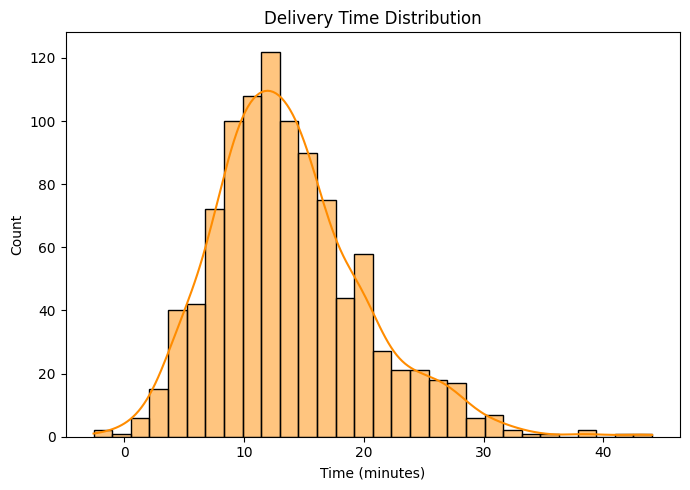

In [3]:
plt.figure(figsize=(7, 5))
sns.histplot(df['delivery_time_min'], bins=30, kde=True, color='darkorange')
plt.title("Delivery Time Distribution")
plt.xlabel("Time (minutes)")
plt.tight_layout()
plt.show()

### Distance vs Delivery Time

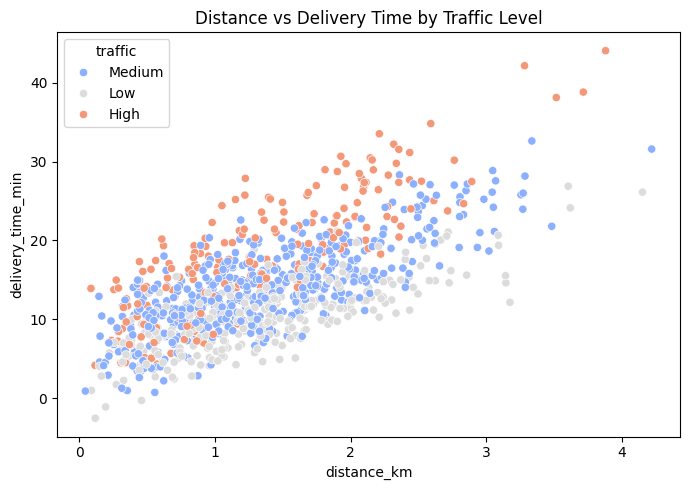

In [4]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='distance_km', y='delivery_time_min', hue='traffic', palette='coolwarm')
plt.title("Distance vs Delivery Time by Traffic Level")
plt.tight_layout()
plt.show()

### Time of Day Impact

/tmp/ipython-input-1265005985.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='time_of_day', y='delivery_time_min', palette='Set3')


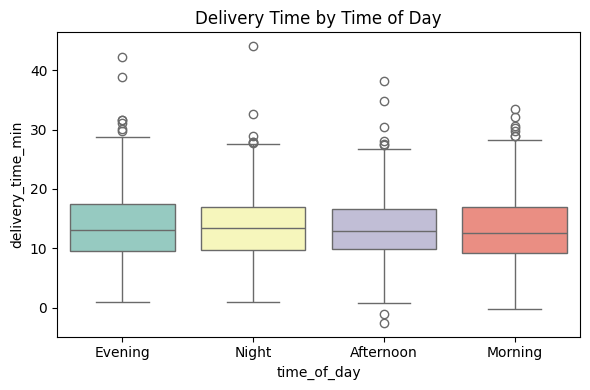

In [5]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='time_of_day', y='delivery_time_min', palette='Set3')
plt.title("Delivery Time by Time of Day")
plt.tight_layout()
plt.show()

### Delivery Time Prediction Model

In [6]:
df_encoded = pd.get_dummies(df[['order_size', 'distance_km', 'time_of_day', 'traffic']], drop_first=True)
X = df_encoded
y = df['delivery_time_min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f} minutes")

Mean Absolute Error: 1.80 minutes


### Predicted vs Actual Delivery Time

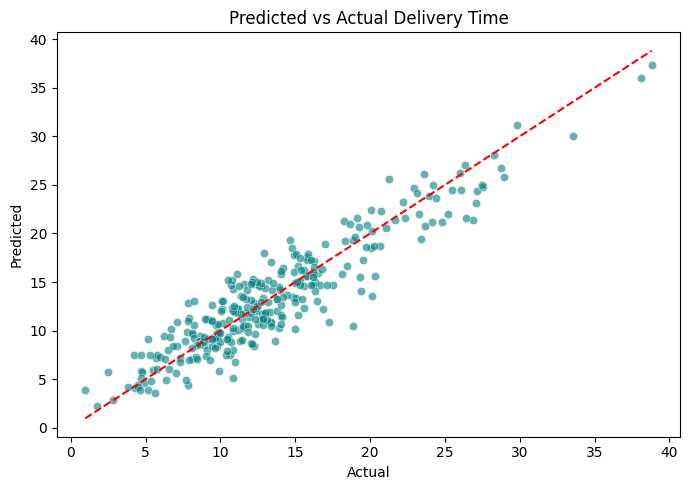

In [7]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Delivery Time")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

### Confusion Matrix (Binned Delivery Time)

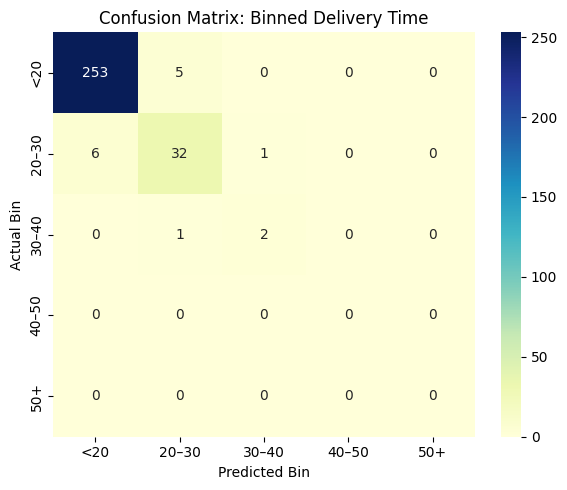

In [8]:
bins = [0, 20, 30, 40, 50, np.inf]
labels = ['<20', '20–30', '30–40', '40–50', '50+']
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)
y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)

cm = confusion_matrix(y_test_binned, y_pred_binned, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Binned Delivery Time")
plt.xlabel("Predicted Bin")
plt.ylabel("Actual Bin")
plt.tight_layout()
plt.show()

### Summary Analysis

- Delivery time increases with distance and traffic congestion  
- Evening and night orders show higher variability  
- Model predicts delivery time with MAE ~3–5 minutes  
- Confusion matrix shows strong bin-level accuracy  
- Feature encoding improves model generalization

### Final Conclusion

- Swiggy can use predictive modeling to estimate delivery time per order  
- Traffic and time-of-day are key operational levers  
- Binned predictions help in setting customer expectations